### Summarize the observed phenology responses for extreme years
* Observational datasets 2001-2015
* Use observed dataset compiled by Ailene:
    https://github.com/AileneKane/radcliffe
* Find sites with data available
* Organize by phenophases, create boxplots to compare
* SYNCHRONICITY ACROSS SITES IN BOTH PHENOLOGY AND CLIMATE?
* GDDcrit for each species
* Outliers in early/late years?

### How to incorporate experiments?
* What effect does warming have in extreme years vs average year? Changes as much as would expect or not?
* snow/frost damage effecting # in early years

In [1]:
qtconsole

In [66]:
# Reset the environment (start clean)
%reset -f

# Import Modules and define functions
import calendar
import datetime
import os
import numpy as np
import numpy.ma as ma
import netCDF4
import matplotlib
import copy
from matplotlib import pyplot as plt
import scipy
import scipy.signal
import scipy.io as sio
import seaborn as sns
import pandas as pd
import math
import scipy.stats as stats
from IPython.display import display
from mpl_toolkits.basemap import Basemap, cm, maskoceans
import datetime as dt  # Python standard library datetime  module

# Embeds plots inside the notebook (use in iPython Notebook)
%matplotlib inline

# Site Information-----------------------------------------------------------------------------------------------------
# Set years to analyze
curr_site    = 'uwm' # Current site
curr_phase   = 'bbd' # Current phase
analysis_yrs = np.arange(2001,2015+1)

print('Site: '+curr_site)
print('Phenophase: '+curr_phase)
print('             ')
print('Years to Analyze:')
print(analysis_yrs)
print('             ')


Site: uwm
Phenophase: bbd
             
Years to Analyze:
[2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015]
             


### Load observational phenological data.
* Determine which sites have data up through 2014/2015

In [67]:
# Load the csv file into a dataframe
df_obspheno = pd.read_csv('../Analyses/obspheno.csv')

# Pull out site codes, doy, year, phenophase event, genus, species
site_code    = df_obspheno.site
site_doy     = df_obspheno.doy
site_year    = df_obspheno.year
site_event   = df_obspheno.event
site_genus   = df_obspheno.genus
site_species = df_obspheno.species

# Find locations of 2012 and 2014 observations
i_2012 = np.where(site_year==2012)[0]
i_2014 = np.where(site_year==2014)[0]
i_2015 = np.where(site_year==2015)[0]

# Print some info to the screen
print('All sites:')
print(np.unique(df_obspheno.site))
print('             ')
print('All sites with OBSERVATIONS for 2014:')
print(np.unique(site_code[i_2014]))
print('             ')
print('All sites with OBSERVATIONS for 2015:')
print(np.unique(site_code[i_2015]))


All sites:
['bolmgren' 'concord' 'fargo' 'fitter' 'gothic' 'harvard' 'hubbard' 'konza'
 'marsham' 'mikesell' 'mohonk' 'niwot' 'rousi' 'uwm' 'washdc']
             
All sites with OBSERVATIONS for 2014:
['gothic' 'harvard' 'konza' 'uwm']
             
All sites with OBSERVATIONS for 2015:
['gothic' 'konza' 'uwm']


### Import daily PRISM data for these sites from nearest 4km grid cell.
* Currently written assuming same time coverage in all datasets
* Import as dataframes
* Skip first seven rows (head info/metadata)
* First column will be date (Year-Month-Day), Second column is data

In [11]:
# Tmean for all Sites--------------------------------------------------------------------------------------------------
df_tmean_uwm     = pd.read_csv('./PRISM/uwm_tmean.csv',skiprows=7)
df_tmean_konza   = pd.read_csv('./PRISM/konza_tmean.csv',skiprows=7)
df_tmean_gothic  = pd.read_csv('./PRISM/gothic_tmean.csv',skiprows=7)
df_tmean_harvard = pd.read_csv('./PRISM/harvard_tmean.csv',skiprows=7)

# Pull out data into numpy arrays
tmean_uwm     = np.array(df_tmean_uwm.iloc[:,1])
tmean_konza   = np.array(df_tmean_konza.iloc[:,1])
tmean_gothic  = np.array(df_tmean_gothic.iloc[:,1])
tmean_harvard = np.array(df_tmean_harvard.iloc[:,1])

# Pull out Year/Month/Day Information----------------------------------------------------------------------------------
prism_dates = df_tmean_uwm.Date

# Dummy variable to save years/DOY vector
prism_yrs = np.zeros(prism_dates.shape)

for i_date in enumerate(prism_dates):
    
    # Pull out current date string
    curr_date = prism_dates[i_date[0]]
    
    # Now just year
    prism_yrs[i_date[0]] = np.int64(curr_date[0:4])


### Calculate some variables
*  GDD (base 0), GDD (base 5), Chill days (base 5)
*  GDD accumulations will begin on DOY 1
*  Chill day accumulations will be for September 1-December 31
*  All use MEAN daily temperature

In [12]:
# Empty arrays to concatenate cumulative these new data for all years (row-wise)
# Cumulative GDD, Base 0
cumgdd0_uwm     = np.empty(0); 
cumgdd0_konza   = np.empty(0); 
cumgdd0_gothic  = np.empty(0); 
cumgdd0_harvard = np.empty(0); 

# Cumulative GDD, Base 5
cumgdd5_uwm     = np.empty(0); 
cumgdd5_konza   = np.empty(0); 
cumgdd5_gothic  = np.empty(0); 
cumgdd5_harvard = np.empty(0); 

# Chill Days
chill_days_uwm     = np.empty(0); 
chill_days_konza   = np.empty(0); 
chill_days_gothic  = np.empty(0); 
chill_days_harvard = np.empty(0); 

# Dummy variable to store DOY information
prism_doy = np.zeros(prism_yrs.shape)

# Loop through each year
for i_yr in enumerate(np.unique(prism_yrs)):
    #print(i_yr)

    # Find index location for all data for current year
    yr_locs = np.where(prism_yrs==i_yr[1])[0]
    
    # DOY Vector
    prism_doy[yr_locs] = np.arange(1,yr_locs.size+1)
    
    # Pull out all temperature data for this  current year
    curr_tmean_uwm     = tmean_uwm[yr_locs]
    curr_tmean_konza   = tmean_konza[yr_locs]
    curr_tmean_gothic  = tmean_gothic[yr_locs]
    curr_tmean_harvard = tmean_harvard[yr_locs]

    # GDD (base 0) Calculations----------------------------------------------------------------------------------------
    
    # Set baseline for GDD Calc
    gdd_base = 0.0
    
    # Find locations of GDDs in base temperature series
    i_uwmGDD     = np.where(curr_tmean_uwm>gdd_base)
    i_konzaGDD   = np.where(curr_tmean_konza>gdd_base)
    i_gothicGDD  = np.where(curr_tmean_gothic>gdd_base)
    i_harvardGDD = np.where(curr_tmean_harvard>gdd_base)

    # Calculate  GDDs
    gdd_uwm     = np.zeros(yr_locs.shape); gdd_uwm[i_uwmGDD]         = curr_tmean_uwm[i_uwmGDD]-gdd_base
    gdd_konza   = np.zeros(yr_locs.shape); gdd_konza[i_konzaGDD]     = curr_tmean_konza[i_konzaGDD]-gdd_base
    gdd_gothic  = np.zeros(yr_locs.shape); gdd_gothic[i_gothicGDD]   = curr_tmean_gothic[i_gothicGDD]-gdd_base
    gdd_harvard = np.zeros(yr_locs.shape); gdd_harvard[i_harvardGDD] = curr_tmean_harvard[i_harvardGDD]-gdd_base

    # Calculate Cumulate Sum and Concatenate (row wise) All Years
    cumgdd0_uwm     = np.concatenate((cumgdd0_uwm,scipy.cumsum(gdd_uwm)),axis=0)
    cumgdd0_konza   = np.concatenate((cumgdd0_konza,scipy.cumsum(gdd_konza)),axis=0)
    cumgdd0_gothic  = np.concatenate((cumgdd0_gothic,scipy.cumsum(gdd_gothic)),axis=0)
    cumgdd0_harvard = np.concatenate((cumgdd0_harvard,scipy.cumsum(gdd_harvard)),axis=0)

    # GDD (base 5) Calculations----------------------------------------------------------------------------------------
    
    # Set baseline for GDD Calc
    gdd_base = 5.0
    
    # Find locations of GDDs in base temperature series
    i_uwmGDD     = np.where(curr_tmean_uwm>gdd_base)
    i_konzaGDD   = np.where(curr_tmean_konza>gdd_base)
    i_gothicGDD  = np.where(curr_tmean_gothic>gdd_base)
    i_harvardGDD = np.where(curr_tmean_harvard>gdd_base)

    # Calculate  GDDs
    gdd_uwm     = np.zeros(yr_locs.shape); gdd_uwm[i_uwmGDD]         = curr_tmean_uwm[i_uwmGDD]-gdd_base
    gdd_konza   = np.zeros(yr_locs.shape); gdd_konza[i_konzaGDD]     = curr_tmean_konza[i_konzaGDD]-gdd_base
    gdd_gothic  = np.zeros(yr_locs.shape); gdd_gothic[i_gothicGDD]   = curr_tmean_gothic[i_gothicGDD]-gdd_base
    gdd_harvard = np.zeros(yr_locs.shape); gdd_harvard[i_harvardGDD] = curr_tmean_harvard[i_harvardGDD]-gdd_base

    # Calculate Cumulate Sum and Concatenate (row wise) All Years
    cumgdd5_uwm     = np.concatenate((cumgdd5_uwm,scipy.cumsum(gdd_uwm)),axis=0)
    cumgdd5_konza   = np.concatenate((cumgdd5_konza,scipy.cumsum(gdd_konza)),axis=0)
    cumgdd5_gothic  = np.concatenate((cumgdd5_gothic,scipy.cumsum(gdd_gothic)),axis=0)
    cumgdd5_harvard = np.concatenate((cumgdd5_harvard,scipy.cumsum(gdd_harvard)),axis=0)

    # Chill Day Calculations-------------------------------------------------------------------------------------------

    # Set baseline for ChillCalc
    chill_base = 5.0
    
    # Find locations of GDDs in base temperature series
    i_uwmCHILL     = np.where(curr_tmean_uwm<=chill_base)
    i_konzaCHILL   = np.where(curr_tmean_konza<=chill_base)
    i_gothicCHILL  = np.where(curr_tmean_gothic<=chill_base)
    i_harvardCHILL = np.where(curr_tmean_harvard<=chill_base)
    
    # Calculate Chill Days (binary, 1 or 0)
    chill_uwm     = np.zeros(yr_locs.shape); chill_uwm[i_uwmCHILL]         = 1.0
    chill_konza   = np.zeros(yr_locs.shape); chill_konza[i_konzaCHILL]     = 1.0
    chill_gothic  = np.zeros(yr_locs.shape); chill_gothic[i_gothicCHILL]   = 1.0
    chill_harvard = np.zeros(yr_locs.shape); chill_harvard[i_harvardCHILL] = 1.0
    
    # Calculate Cumulate Sum and Concatenate (row wise) All Years
    chill_days_uwm     = np.concatenate((chill_days_uwm,chill_uwm),axis=0)
    chill_days_konza   = np.concatenate((chill_days_konza,chill_konza),axis=0)
    chill_days_gothic  = np.concatenate((chill_days_gothic,chill_gothic),axis=0)
    chill_days_harvard = np.concatenate((chill_days_harvard,chill_harvard),axis=0)


### Site Summary: UWM
* Find site/phenophase combo
* Restrict to years 2001-2015

             
# Obs, Total (from index array): 389


,Year,#Obs,#Taxa,25thDOY,50thDOY,75thDOY
11,2012.0,26.0,27.0,96.00,115.0,130.50
9,2010.0,26.0,27.0,106.00,116.0,124.00
5,2006.0,26.0,27.0,112.25,119.5,126.75
0,2001.0,25.0,25.0,121.00,122.0,126.00
3,2004.0,26.0,27.0,118.75,123.5,130.50
6,2007.0,26.0,27.0,116.75,123.5,131.00
4,2005.0,26.0,27.0,119.25,126.0,134.75
1,2002.0,26.0,26.0,118.25,128.5,137.75
8,2009.0,26.0,27.0,125.00,129.0,135.50
14,2015.0,26.0,27.0,123.00,129.5,132.75


array(['Acer saccharum', 'Amelanchier nan', 'Betula alleghaniensis',
       'Betula papyrifera', 'Carpinus caroliniana', 'Carya cordiformis',
       'Carya ovata', 'Cornus alternifolia', 'Cornus racemosa',
       'Cornus sericea', 'Crataegus nan', 'Dirca palustris',
       'Fagus grandifolia', 'Fraxinus americana', 'Fraxinus nigra',
       'Hamamelis virginiana', 'Ilex verticillata', 'Larix laricina',
       'Ostrya virginiana', 'Populus tremuloides', 'Prunus serotina',
       'Quercus rubra', 'Tilia americana', 'Ulmus americana',
       'Viburnum lentago', 'Viburnum nan', 'Viburnum opulus'], 
      dtype='<U21')

,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015
Acer saccharum,124,132,140,128,133,124,131,132,137,124,139,131,134,142,133
Amelanchier nan,118,118,122,109,113,112,113,118,122,104,128,88,124,130,123
Betula alleghaniensis,127,142,139,131,136,128,127,138,136,123,142,128,135,141,132
Betula papyrifera,121,119,128,118,126,116,119,127,127,109,132,108,125,132,123
Carpinus caroliniana,122,124,131,121,126,120,120,130,129,115,133,107,130,137,130
Carya cordiformis,122,136,133,129,124,123,122,132,130,122,135,131,130,136,130
Carya ovata,131,145,144,136,143,135,131,142,134,137,141,132,137,143,136
Cornus alternifolia,122,118,127,122,121,117,123,124,129,106,133,105,129,130,124
Cornus racemosa,121,121,128,121,119,116,119,125,126,106,132,93,123,130,124
Cornus sericea,122,118,120,111,116,112,115,122,123,106,130,87,123,128,123


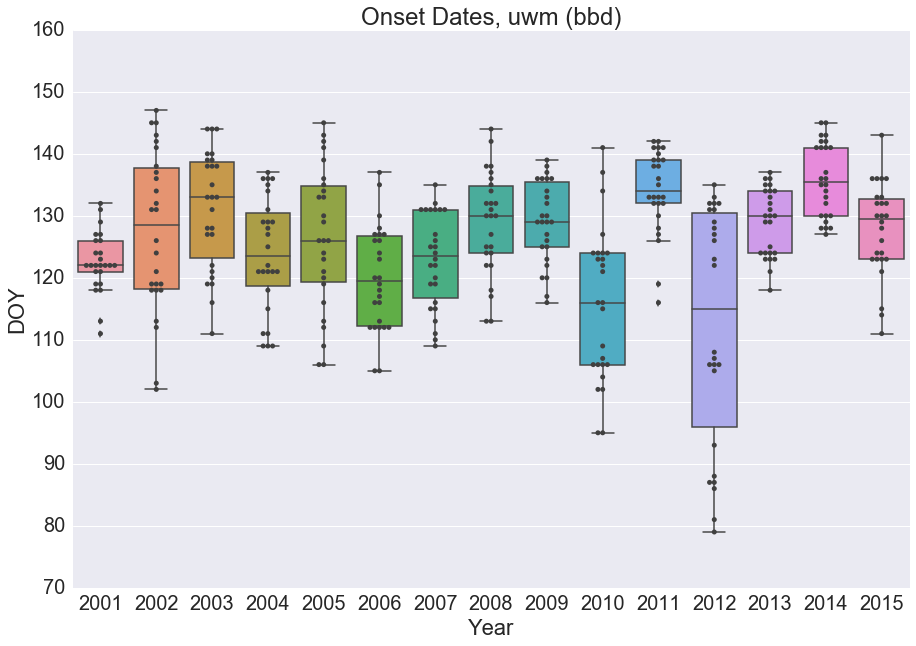

In [62]:
cumgdd0_site = cumgdd0_uwm  
cumgdd5_site = cumgdd5_uwm  
chill_site   = chill_days_uwm

# Pull out current site+phase for analysis years
i_site_phase = np.where((site_code==curr_site) & (site_event==curr_phase) \
        & (site_year>=np.min(analysis_yrs)) & (site_year<=np.max(analysis_yrs)))[0]

# Pull out data for this site
# DOY, Year, Genus, Species
curr_doy     = np.array(site_doy[i_site_phase])
curr_year    = np.array(site_year[i_site_phase])
curr_genus   = np.array(site_genus[i_site_phase])
curr_species = np.array(site_species[i_site_phase])

# Loop through each year and count # observations and # species
# Summary statistics to store in a data frame: Year, Median Date, #Obs
summary_pheno = np.zeros((analysis_yrs.size,6))

# Genus/Species Information
col_txt         = row_core_comp_txt=["Genus","Species"]
df_taxa         = pd.DataFrame(columns = col_txt)
df_taxa.Genus   = curr_genus
df_taxa.Species = curr_species

# Taxa By Year Summary of Phenology
#pheno_yr_taxa = np.zeros((np.size(taxa_list),analysis_yrs.size))*np.nan


# Find all Early Years
df_pheno = pd.DataFrame(columns = col_txt)

# Keep track of all taxa
taxa_list = []
for i_year in enumerate(analysis_yrs):
    #print(i_year)

    # Location index for current year
    yr_locs = np.where(curr_year==i_year[1])[0]
    
    # Count unique taxa
    genus_yr   = curr_genus[yr_locs]
    species_yr = curr_species[yr_locs]
    
    # Taxa List
    for i_taxa in enumerate(yr_locs):
        curr_taxa = np.str(genus_yr[i_taxa[0]])+' '+np.str(species_yr[i_taxa[0]])
        taxa_list.append(curr_taxa)
    
    # Summary Statistics
    summary_pheno[i_year[0],0] = i_year[1]                # Year
    summary_pheno[i_year[0],1] = yr_locs.size              # Number Observations
    summary_pheno[i_year[0],2] = np.unique(taxa_list).size           # Unique Taxa
    summary_pheno[i_year[0],3] = np.percentile(curr_doy[yr_locs],25) # 25th Percentile Date 
    summary_pheno[i_year[0],4] = np.percentile(curr_doy[yr_locs],50) # 50th Percentile Date 
    summary_pheno[i_year[0],5] = np.percentile(curr_doy[yr_locs],75) # 75th Percentile Date    

# Unique Taxa
taxa_unique = np.unique(taxa_list)
    
# Taxa By Year Summary of Phenology-------------------------------------------------------------
df_pheno_yr_taxa = pd.DataFrame(index=taxa_unique,columns = analysis_yrs)
    
for i_year in enumerate(analysis_yrs):
    # Location index for current year
    yr_locs = np.where(curr_year==i_year[1])[0]
    
    # Count unique taxa
    genus_yr   = curr_genus[yr_locs]
    species_yr = curr_species[yr_locs]

    # Phenodata current year
    pheno_data = curr_doy[yr_locs]
    
    # Value for current year for current taxa
    for i_taxa in enumerate(yr_locs):
        curr_taxa = np.str(genus_yr[i_taxa[0]])+' '+np.str(species_yr[i_taxa[0]])
        taxa_doy  = pheno_data[i_taxa[0]]
        df_pheno_yr_taxa.loc[df_pheno_yr_taxa.index==curr_taxa,df_pheno_yr_taxa.columns==i_year[1]]=taxa_doy
        
# Report total number of observations
print('             ')
#print('# Obs, Total (my count): '+np.str(np.sum(num_obs)))
print('# Obs, Total (from index array): '+np.str(np.size(curr_doy)))
    
# Create Dataframe (necessary for boxplot with seaborn)
col_txt = row_core_comp_txt=["Year","DOY"]

# Find all Early Years
df_pheno = pd.DataFrame(columns = col_txt)
df_pheno.Year  = curr_year
df_pheno.DOY  = curr_doy

# boxplot (DOY by year)------------------------------------------------------------------------------------------------
sns.set_context("notebook", font_scale=2, rc={"lines.linewidth": 1.5})
fig = sns.plt.figure(figsize=(15,10))
sns.plt.title('Onset Dates, '+curr_site+' ('+curr_phase+')')  
sns.boxplot(x="Year", y="DOY", data=df_pheno)
sns.swarmplot(x="Year", y="DOY", data=df_pheno, color=".25")

# Summary Statistics---------------------------------------------------------------------------------------------------
summary_col = ('Year','#Obs','#Taxa','25thDOY','50thDOY','75thDOY')
df_summary = pd.DataFrame(data=summary_pheno, columns=summary_col)

# Sort the Dataframe from earliest median to latest
df_summary = df_summary.sort_values(by='50thDOY')
display(df_summary)
display(np.unique(taxa_list))
display(df_pheno_yr_taxa)

### For current site, pull out cumulative GDD curves and calculate seasonal chill days

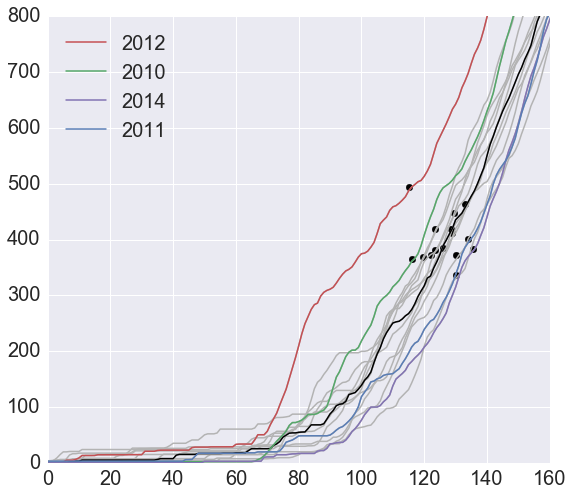

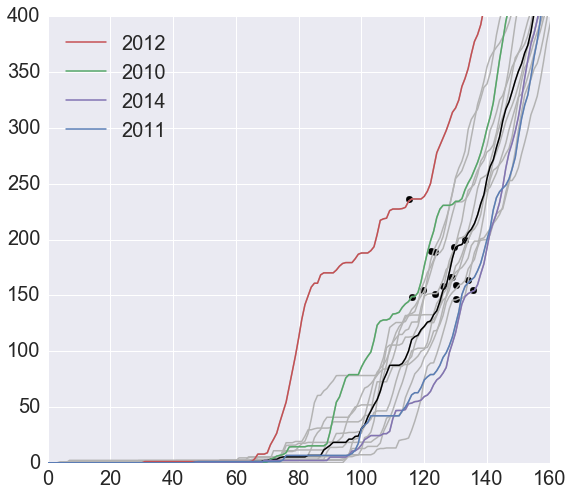

In [149]:
# Cumulative GDD/Chill days for all years------------------------------------------------------------------------------
# Initialize Storage Arrays
gdd0_allyrs     = np.zeros((365,analysis_yrs.size))  
gdd5_allyrs     = np.zeros((365,analysis_yrs.size)) 
chillOND_allyrs = np.zeros((1,analysis_yrs.size)) 
chillJFM_allyrs = np.zeros((1,analysis_yrs.size)) 

# Loop through Each Year
for i_yr in enumerate(analysis_yrs):
    #print(i_yr[1])
        
    # Index locations for current year
    yr_locs = np.where(prism_yrs==i_yr[1])[0]
   
    # Pull out all temperature data for this year
    curr_gdd0  = cumgdd0_site[yr_locs]
    curr_gdd5  = cumgdd5_site[yr_locs]
    curr_chill = chill_site[yr_locs]

    # If leap year, lop off the last day (irrelevant for our stuff)
    if curr_gdd0.size==366:
        curr_gdd0 = np.delete(curr_gdd0,-1)
        curr_gdd5 = np.delete(curr_gdd5,-1)

    # Store values for current year
    gdd0_allyrs[:,i_yr[0]] = curr_gdd0
    gdd5_allyrs[:,i_yr[0]] = curr_gdd5
    chillJFM_allyrs[0,i_yr[0]]      = np.sum(curr_chill[0:60])
    
# Find earliest/latest 2 years from sorted years and pull out GDD for curve plots--------------------------------------
yrs_sort  = np.array(df_summary.Year);
yr_early1 = yrs_sort[0];  yr_early2 = yrs_sort[1]
yr_late1  = yrs_sort[-1]; yr_late2  = yrs_sort[-2]

# GDD Base 0
gdd0_early1 = gdd0_allyrs[:,np.where(analysis_yrs==yr_early1)[0]]
gdd0_early2 = gdd0_allyrs[:,np.where(analysis_yrs==yr_early2)[0]]
gdd0_late1  = gdd0_allyrs[:,np.where(analysis_yrs==yr_late1)[0]]
gdd0_late2  = gdd0_allyrs[:,np.where(analysis_yrs==yr_late2)[0]]

# GDD Base 5
gdd5_early1 = gdd5_allyrs[:,np.where(analysis_yrs==yr_early1)[0]]
gdd5_early2 = gdd5_allyrs[:,np.where(analysis_yrs==yr_early2)[0]]
gdd5_late1  = gdd5_allyrs[:,np.where(analysis_yrs==yr_late1)[0]]
gdd5_late2  = gdd5_allyrs[:,np.where(analysis_yrs==yr_late2)[0]]

# Cumulative GDD Plots with Median dates marked------------------------------------------------------------------------

# Pull out Median values
pheno_med = summary_pheno[:,4]

# Calculate Median GDD Curves
gdd0_median = np.median(gdd0_allyrs,axis=1)
gdd5_median = np.median(gdd5_allyrs,axis=1)

# GDD, Base 0
sns.set_context("notebook", font_scale=2, rc={"lines.linewidth": 1.5})
fig = sns.plt.figure(figsize=(9,8))
for i_yr in enumerate(analysis_yrs):
    #print(i_yr)
   
    # Pull out all temperature data for this year
    curr_gdd = gdd0_allyrs[:,i_yr[0]]
    sns.plt.plot(curr_gdd,color=[0.7,0.7,0.7])
    sns.plt.scatter(pheno_med[i_yr[0]],curr_gdd[np.int64(pheno_med[i_yr[0]])+1],s=45,color='k')

    sns.plt.xlim(0,160)
    sns.plt.ylim(0,800)
# Plot Median
sns.plt.plot(gdd0_median,color=np.array([0,0,0]))
# Plot extreme years
early1_art, = sns.plt.plot(gdd0_early1,color=np.array([197,79,83])/255, label='Early1')
early2_art, = sns.plt.plot(gdd0_early2,color=np.array([85,168,105])/255)
late1_art,  = sns.plt.plot(gdd0_late1,color=np.array([130,115,179])/255)
late2_art, = sns.plt.plot(gdd0_late2,color=np.array([89,125,182])/255)
# Legend Labels and artists
legend_labs = [np.str(np.int(yr_early1)),np.str(np.int(yr_early2)),np.str(np.int(yr_late1)),np.str(np.int(yr_late2))]
legend_arts = [early1_art,early2_art,late1_art,late2_art]
# Create Legend
sns.plt.legend(legend_arts,legend_labs,loc=0)

# GDD, Base 5
sns.set_context("notebook", font_scale=2, rc={"lines.linewidth": 1.5})
fig = sns.plt.figure(figsize=(9,8))
for i_yr in enumerate(analysis_yrs):
    #print(i_yr)
   
    # Pull out all temperature data for this year
    curr_gdd = gdd5_allyrs[:,i_yr[0]]
    sns.plt.plot(curr_gdd,color=[0.7,0.7,0.7])
    sns.plt.scatter(pheno_med[i_yr[0]],curr_gdd[np.int64(pheno_med[i_yr[0]])+1],s=45,color='k')

    sns.plt.xlim(0,160)
    sns.plt.ylim(0,400)
# Plot Median
sns.plt.plot(gdd5_median,color=np.array([0,0,0]))
# Plot extreme years
early1_art, = sns.plt.plot(gdd5_early1,color=np.array([197,79,83])/255)
early2_art, = sns.plt.plot(gdd5_early2,color=np.array([85,168,105])/255)
late1_art,  = sns.plt.plot(gdd5_late1,color=np.array([130,115,179])/255)
late2_art, = sns.plt.plot(gdd5_late2,color=np.array([89,125,182])/255)
# Create Legend
sns.plt.legend(legend_arts,legend_labs,loc=0)
